# Description of this work package

Let us assume that you are the operator of a factory, where bearings are critical components in your machine. The failure of bearings is catastrophic for the machine so the failure cost of the bearing is estimated to be $C_1 = 100 000$ euros. The price of a bearing is $1000$ euros. From the vendor, you obtained a result of life testing of the bearings conducted by the vendor (see the attached excel file). The unit of the lifetime is already transformed into days. Please note that the testing is censored after 600 days. You goal is to decide a best maintenance strategy for the bearings. You are considering three options:
- Implement a corrective maintenance strategy: Replace the bearing only when the bearing fails.
- Purchase a online condition-monitoring system from Siemens: The sensor will monitor the state of the bearing and issue a warning when the failure is about to occur. So that you have an opportunity to replace the bearing just before the failure is going to happen.
- Implement a preventive maintenance strategy: Replace the bearing preventively based on a pre-defined time/age.

In this project, you are going to help the operator to choose the best maintenance plan by doing some analyses.

# Task 1: Estimate the expected cost rate of a corrective maintenance strategy.

The purpose of this task is to calculat the expected cost rate of a corrective maintenance strategy. Expected cost rate $C(t)$ is defined as:
$$ EC(t) = E \lim_{t\rightarrow \infty} \frac{\sum_{i=1}^{N(t)} C_i}{t}$$
where $N(t)$ is the number of failures before $t$ and $C_i$ is the cost per failure.

To solve this problem, first we need to fit the life testing data of the bearing and determine a best lifetime distribution. Hint: You can get some help from this notebook: https://colab.research.google.com/drive/1a0xxZ6eDUjpmoHS4URgeFr-D01qqZ7R5?usp=sharing. Then, according to renewal process theory, $E C(t)$ can be calculated by (see lecture slide for details) $E C(T) = \frac{C_i}{MTTF}.$

In [14]:
! pip install reliability

In [15]:
import pandas as pd 

def read_test_data(page):
    filename = 'bearing_data.xlsx'
    df = pd.read_excel(filename, sheet_name=page, usecols='A', header=14, nrows=86)
    df = df.rename(columns={650:'Time to failure'})
    return df

Results from Fit_Everything:
Analysis method: MLE
Failures / Right censored: 86/0 (0% right censored) 

   Distribution   Alpha    Beta   Gamma Alpha 1  Beta 1 Alpha 2  Beta 2 Proportion 1 DS      Mu    Sigma     Lambda  Log-likelihood    AICc     BIC       AD optimizer
Weibull_Mixture                         669.846 31.8413 786.311 26.3863     0.725369                                       -447.215  905.18 916.702 0.336112       TNC
       Gamma_3P 35.6297 2.59157 596.787                                                                                    -458.103 922.499 929.569  1.41873       TNC
   Lognormal_3P                 573.826                                                 4.63075 0.486099                   -458.238 922.769 929.839   1.2227       TNC
     Weibull_3P 96.2783 1.55822 602.612                                                                                    -458.257 922.806 929.876  1.66432       TNC
 Loglogistic_3P 88.6709 3.13828 586.022                      

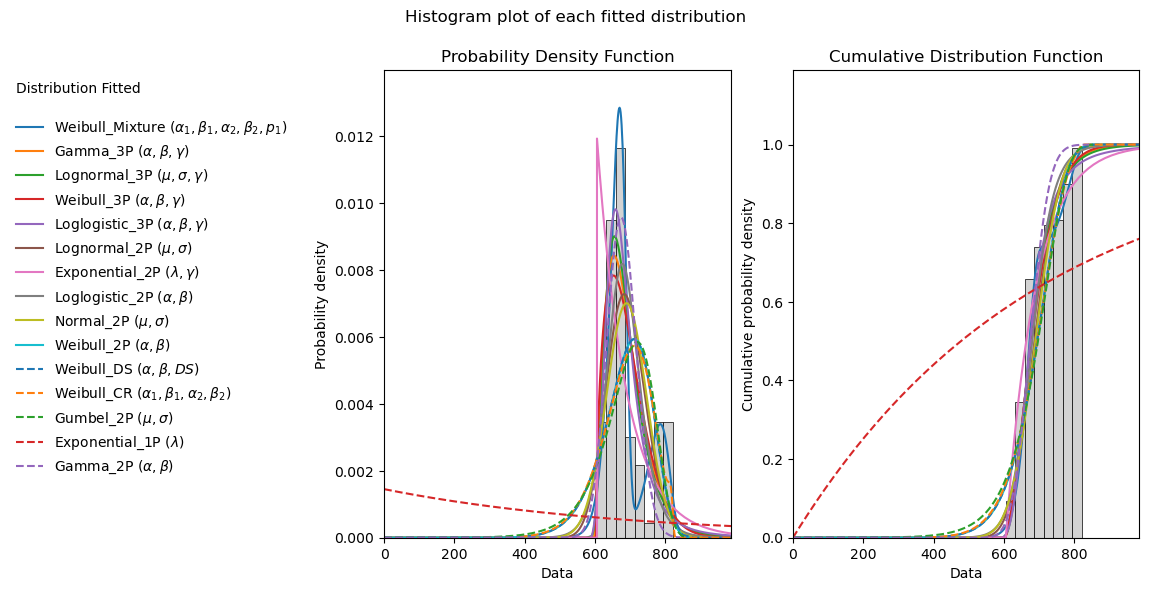

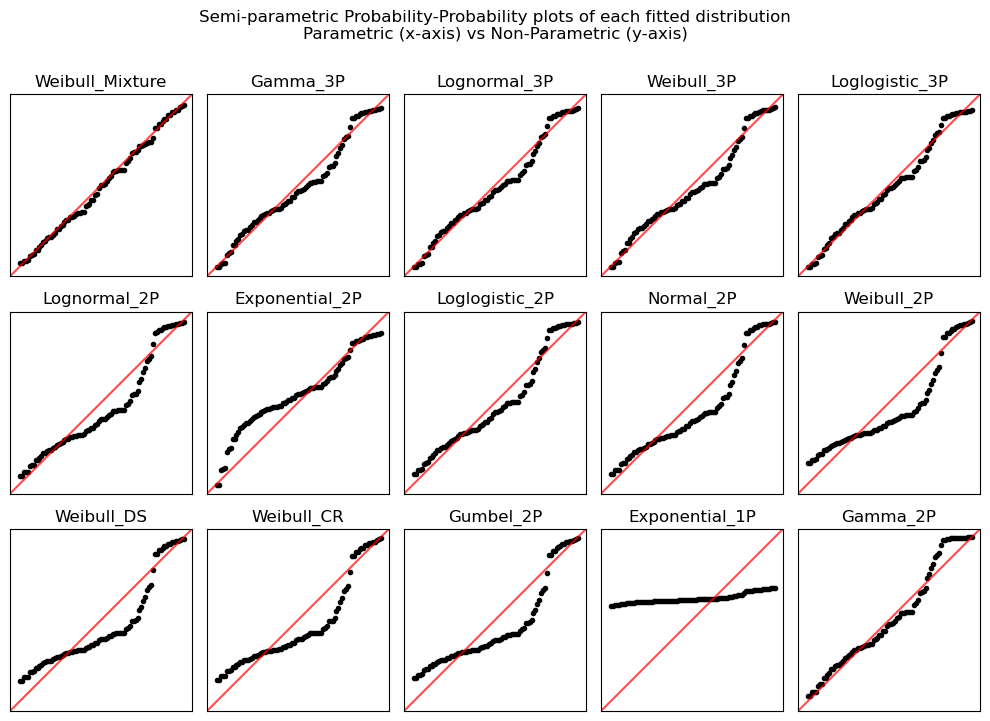

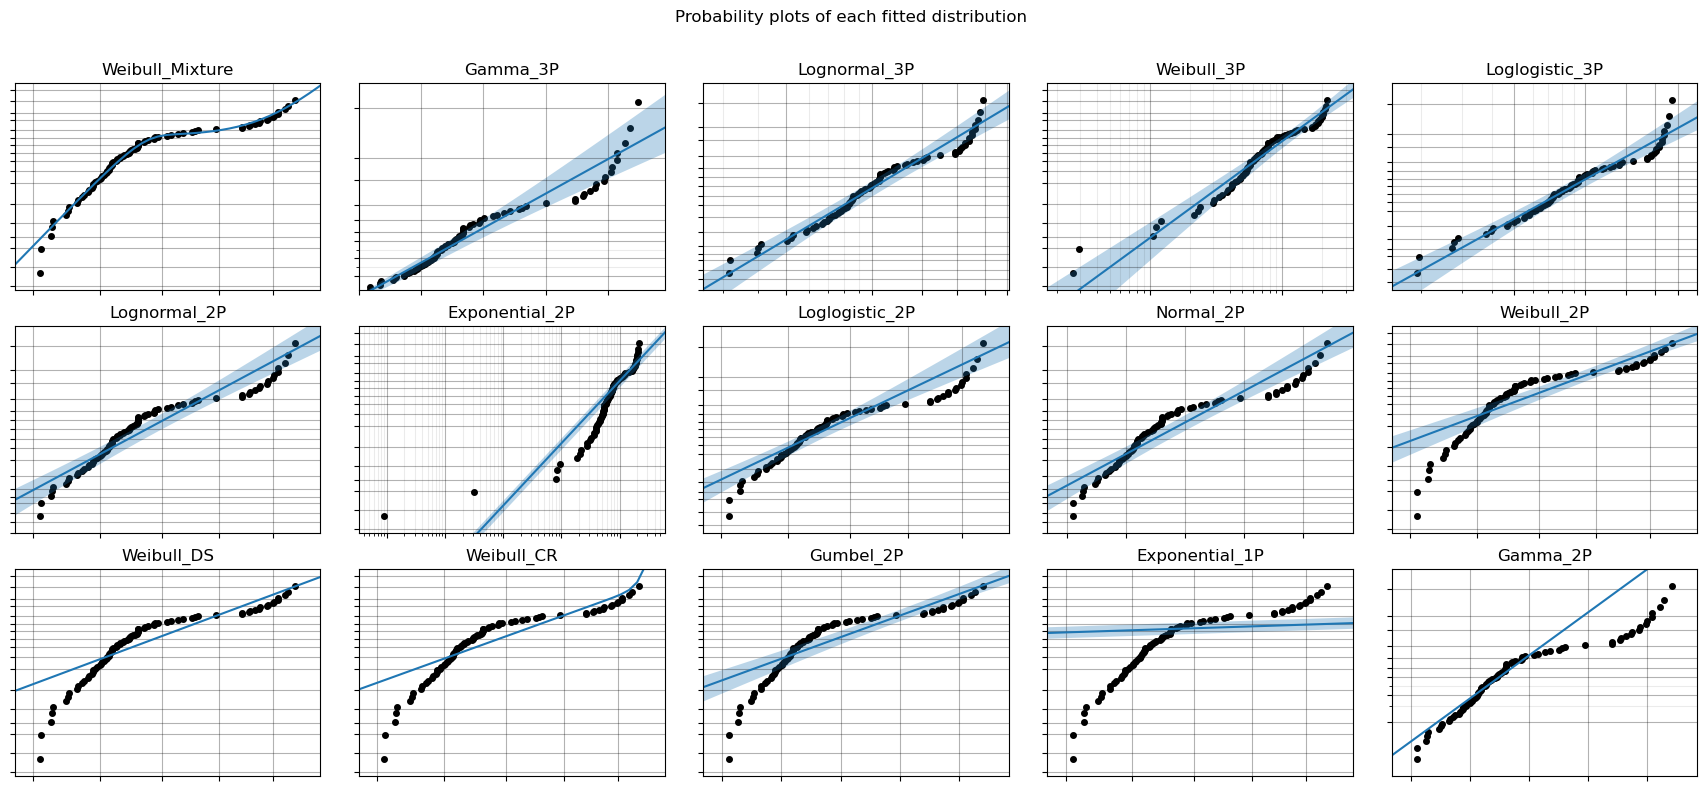

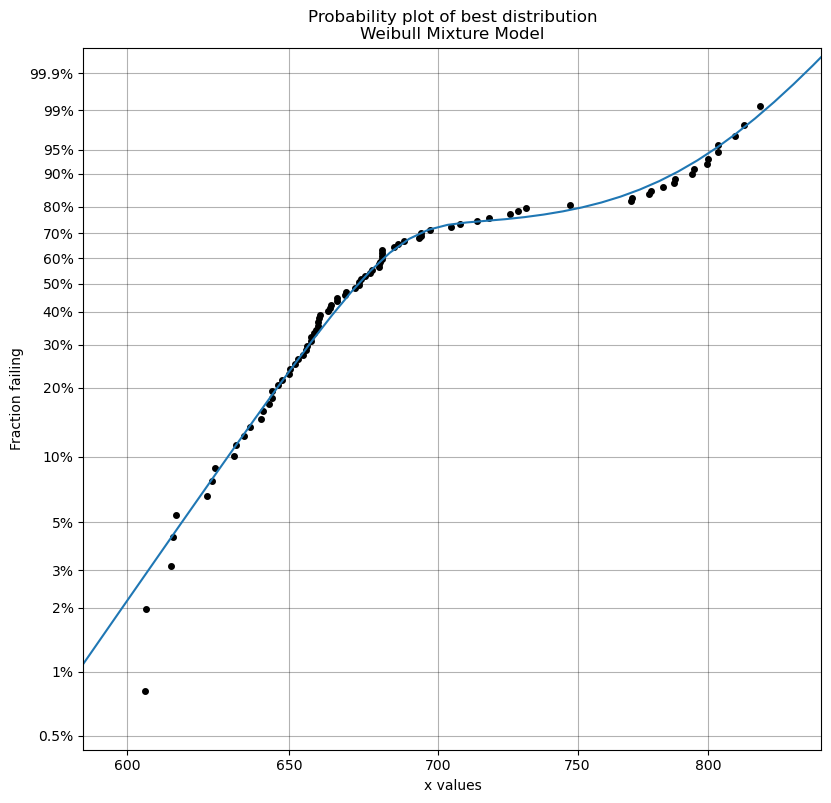

In [16]:
from reliability.Fitters import Fit_Everything
import matplotlib.pyplot as plt

data = read_test_data(0)
data = data.to_numpy().flatten()
data

# MLE on the Weibull distribution.
result = Fit_Everything(failures=data)
plt.show()

In [17]:
best_distribution = result.best_distribution
print(best_distribution)

In [18]:
Ci = 100000
Mttf = best_distribution.mean
EC = Ci/Mttf
EC

145.126019049607

# Task 2: Estimate the expected cost rate if we implement the Siemens model.

In the model you developed for Siemens, when the algorithm predicts a label "1", it actually indicates an inbalanced in the rotation of the bearing. The bearing does not fail yet, but it is an indication that a failure is going to happen soon. It is fair to assume that if we replace the bearing when the model predicts "1", we only need to pay the cost of the bearing itself, not the failure cost $C_1$. However, since your model is not perfect, it might have "false alarm" and "missing alarm". When a false alarm happens, you will replace a healthy bearing with $C_2 = 1000$ euros; while when a missing alarm happens, you will pay cost $C_1$ as your model did not detect the failure. If a failure happens and it is detected by your model, then the cost will be $C_2$ as well. The goal for this task is, then, to estimate the expected cost rate if we implement this "imperfect model", so that we could compare it to the other maintenance strategies.

Hints: 
- You can use the results of your cross validation to estimate the false alarm and missing alarm probability.
- To calculate expected cost rate for a complex system, we could use Monte Carlo simulation to estimate the average cost rate over $t$, and let $t$ increases until this value converges.

In [33]:
from reliability.Distributions import Weibull_Distribution
from reliability.Distributions import Exponential_Distribution
import numpy as np
import scipy.stats as st

## Parameter definitions
# t
evaluation_horizon = 1000
# Number of sample paths
n_s = 10000
# Parameters of age replacement
c_1 = 100000; # Corrective maintenance cost
c_2 = 1000; # Preventive maintenance cost

ttf_list = []
conteos = []

p_1_1 = 0.878
p_0_1 = 1-p_1_1

## Run simulation
# Define intial values
cost = np.zeros(n_s) # Total cost
n_cm = np.zeros(n_s) # Number of failures (Corrective replacements)
n_pm = np.zeros(n_s) # Number of preventive replacements
# Simulation starts
for i in range(n_s):
  t = 0
  temp_cost = 0
  temp_n_cm = 0
  temp_n_pm = 0 

  # Simulate one sample path.
  while t < evaluation_horizon:
    # Generate next failure time
    ttf = best_distribution.random_samples(number_of_samples=1) # Generate time to failure   
    print(ttf) 
    ttf_list.append(ttf)
    t = t + ttf

    sequence = np.random.choice([0, 1], size=10, p=[p_0_1, p_1_1])
    count_1s = np.count_nonzero(sequence == 1)
    count_0s = np.count_nonzero(sequence == 0)
    conteos.append((count_0s, count_1s))
    print(sequence)
    print("Number of 1's:", count_1s)
    print("Number of 0's:", count_0s)

    # if t > T_PM[idx_next_PM]: # If failure occurs after PM
    #   temp_n_pm += 1 # Do a preventive maintenance
    #   t = T_PM[idx_next_PM] # Reset the current time to the current preventive maintenance time. 
    #   temp_cost += c_2         
    # else: # If failure occurs before PM
    #   temp_n_cm += 1 # Failure happens, do a corrective maintenance.
    #   temp_cost += c_1 # Add one corrective maintenance cost.

    cost[i] = temp_cost
    n_cm[i] = temp_n_cm
    n_pm[i] = temp_n_pm
     
     # If failure occurs after PM
     # Do a preventive maintenance.
     # Add the preventive maintenance cost
     # Update current time
     # If failure occurs before PM
     # Failure occures: Do a corrective replacement.
     # Add the corrective maintenance cost.
     # Update current time
print(ttf_list)

[654.55857728]
[1 1 1 1 1 0 1 0 0 1]
Number of 1's: 7
Number of 0's: 3
[662.08886776]
[1 1 1 1 1 0 0 1 1 1]
Number of 1's: 8
Number of 0's: 2
[635.84664064]
[1 1 1 0 1 1 1 1 1 0]
Number of 1's: 8
Number of 0's: 2
[633.80235232]
[1 1 1 1 1 1 1 1 1 1]
Number of 1's: 10
Number of 0's: 0
[628.208166]
[1 1 0 1 1 1 1 1 1 1]
Number of 1's: 9
Number of 0's: 1
[676.30919969]
[1 1 1 1 0 1 1 1 1 1]
Number of 1's: 9
Number of 0's: 1
[649.60172461]
[1 1 1 1 0 1 1 0 1 1]
Number of 1's: 8
Number of 0's: 2
[651.82762781]
[1 1 1 1 0 1 1 1 1 1]
Number of 1's: 9
Number of 0's: 1
[654.92012539]
[1 1 0 1 1 1 1 1 1 1]
Number of 1's: 9
Number of 0's: 1
[653.59220682]
[1 1 1 1 1 1 1 1 1 1]
Number of 1's: 10
Number of 0's: 0
[682.25652602]
[1 0 0 1 1 1 1 1 1 1]
Number of 1's: 8
Number of 0's: 2
[781.50848996]
[1 1 1 1 1 1 1 0 1 1]
Number of 1's: 9
Number of 0's: 1
[642.54228749]
[1 1 1 1 1 1 1 1 0 0]
Number of 1's: 8
Number of 0's: 2
[650.48905898]
[1 1 1 1 1 1 1 1 1 1]
Number of 1's: 10
Number of 0's: 0
[613.

In [ ]:
# Crear un DataFrame de pandas con los conteos
df = pd.DataFrame(conteos, columns=['Número de 0\'s', 'Número de 1\'s'])

# Calcular el conteo de combinaciones únicas
conteo_combinaciones = df.groupby(['Número de 0\'s', 'Número de 1\'s']).size().reset_index(name='Conteo')

# Imprimir la tabla de conteo de combinaciones
print(conteo_combinaciones)

In [29]:
print(cost)
print(n_cm)
print(n_pm)

[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]


In [30]:
num_elementos = len(ttf_list)
print("Número de ttf:", num_elementos)
print("Mean de los elementos", np.mean(ttf_list))

Número de ttf: 20000
Mean de los elementos 688.8103912720186


In [ ]:
# from reliability.Distributions import Weibull_Distribution, Mixture_Model
# import matplotlib.pyplot as plt

# #Create an object for the Wibull distribution
# alpha_1 = 669.846
# beta_1 = 31.8413
# alpha_2 = 786.311
# beta_2 = 26.3863
# wbl_dist1 = Weibull_Distribution(alpha_1, beta_1)
# wbl_dist2 = Weibull_Distribution(alpha_2, beta_2)


# wbl_mixture = Mixture_Model(distributions=[wbl_dist1, wbl_dist2], proportions=[0.274631, 0.725369])
# wbl_mixture.plot()

In [ ]:
# #Estimation of false alarm and missing alarm probability
# from scipy.optimize import minimize_scalar
# import scipy.integrate as integrate
# from reliability.Distributions import Weibull_Distribution
# import numpy as np

# # Parameters of age replacement
# c_1 = 1000; # Correstive maintenance cost
# c_2 = 100; # Preventive maintenance cost
# # Time to failure distribution
# lifetime_dist = Weibull_Distribution(alpha=100, beta=1.5)
# # Define an anomynous function to calculate the expected cost rate.
# EC_T = lambda T: (c_1*lifetime_dist.CDF(xvals=T, show_plot=False) + 
#                  c_2*(1 - lifetime_dist.CDF(xvals=T, show_plot=False)))/integrate.quad(
#                      lambda x: 1-lifetime_dist.CDF(xvals=x, show_plot=False), 0, T)[0]
# result_a = minimize_scalar(EC_T, method='brent')
# # print('T*_a = ' + str(result_a.x))
# # print('Optimal expected cost rate: ' + str(result_a.fun))

# # k1 = 2.0
# # k2 = 3.0
# # lam1 = 1.0
# # lam2 = 2.0
# # p = 0.7
# # # Definir la distribución Weibull_Mixture personalizada
# # class WeibullMixture(rv_continuous):
# #     def _pdf(self, x, k1, k2, lam1, lam2, p):
# #         return p * k1/lam1 * (x/lam1)**(k1-1) * np.exp(-(x/lam1)**k1) + (1-p) * k2/lam2 * (x/lam2)**(k2-1) * np.exp(-(x/lam2)**k2)

# # # Crear una instancia de la distribución personalizada
# # weibull_mixture = WeibullMixture(a=0, b=np.inf, name='weibull_mixture')

# # # Obtener los parámetros óptimos del ajuste
# # best_params = result.best_params  # Reemplaza "result" con el objeto que contiene los resultados del ajuste

# # # Crear una instancia de la distribución Weibull_Mixture con los parámetros óptimos
# # instance = weibull_mixture(*best_params)

# # # Generar números aleatorios de la distribución Weibull_Mixture
# # num_samples = 1000
# # samples = instance.rvs(size=num_samples)
